### Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

### The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

### Imports and Config

In [25]:
# Main
import numpy as np
import pandas as pd


# Model / pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
# Define base directory relative to this notebook
import os

base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path = os.path.join(base_dir, "data", "raw", "reviews.csv")

print("Base directory:", base_dir)
print("Data file:", data_path)

Base directory: c:\Users\P319970\git_delivery\git__project2
Data file: c:\Users\P319970\git_delivery\git__project2\data\raw\reviews.csv


### Load Data

In [5]:
df = pd.read_csv(data_path)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


### Preparing features (`X`) & target (`y`)

In [6]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [7]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

### Data Exploration

In [8]:
# Basic information
print("Shape of data:", data.shape)
print("\nColumn names:\n", data.columns.tolist())
print("\nData types:\n")
print(data.dtypes)

Shape of data: (18442, 9)

Column names:
 ['Clothing ID', 'Age', 'Title', 'Review Text', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name', 'Recommended IND']

Data types:

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
Recommended IND             int64
dtype: object


In [9]:
# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
Clothing ID                0
Age                        0
Title                      0
Review Text                0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
Recommended IND            0
dtype: int64


In [10]:
# Check target distribution
print("\nTarget value counts (Recommended IND):")
print(y.value_counts())
print("\nTarget distribution (%):")
print(round(y.value_counts(normalize=True) * 100, 2))


Target value counts (Recommended IND):
Recommended IND
1    15053
0     3389
Name: count, dtype: int64

Target distribution (%):
Recommended IND
1    81.62
0    18.38
Name: proportion, dtype: float64


In [11]:
# Display statistics for numeric features
print("\nDescriptive statistics for numeric columns:")
display(data.describe())


Descriptive statistics for numeric columns:


,Clothing ID,Age,Positive Feedback Count,Recommended IND
count,18442.000000,18442.000000,18442.000000,18442.000000
mean,954.896757,43.383635,2.697484,0.816235
std,141.571783,12.246264,5.942220,0.387303
min,2.000000,18.000000,0.000000,0.000000
25%,863.000000,34.000000,0.000000,1.000000
50%,952.000000,41.000000,1.000000,1.000000
75%,1078.000000,52.000000,3.000000,1.000000
max,1205.000000,99.000000,122.000000,1.000000


In [12]:
# Check the random review texts for first impression
print("\nExample review texts:")
for i, text in enumerate(data["Review Text"].dropna().sample(3, random_state=42)):
    print(f"--- Review {i+1} ---")
    print(text[:300], "\n")


Example review texts:
--- Review 1 ---
This top is so soft and with a henley neck opening and longer ribbed shirttail hems, it not only feels heavenly against the skin but it gives off a casual chic vibe. it is also great for layering under shorter sweaters and sweatshirts to give my staples a little oomph. it is a bit sheer so cami is a 

--- Review 2 ---
Delighted with these. made in the usa was a big selling factor. great quality and fit. will look out for more active wear from this brand. 

--- Review 3 ---
It was bit on pricey side but it was love at first sight! i couldn't let go after i tried it on..it is soft, lightweight, moves with me, keeps me warm (not just from top up)..it feels silky to the touch and is very versatile and stylish..

runs true to size and it expands a bit the more you wear i 



### Building Pipeline

In [13]:
# Define feature groups
text_features = ["Review Text"]
numeric_features = ["Age", "Positive Feedback Count"]
categorical_features = ["Division Name", "Department Name", "Class Name", "Clothing ID"]

In [14]:
# Build numeric pipeline: handle missing values + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [15]:
# Build categorial pipeline: handle missing values + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [16]:
# Build textual pipeline: TF-IDF vectorization with stopword removal and normalization
text_transformer = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(stop_words="english",
                              ngram_range=(1,2),
                              min_df=2,
                              max_df=0.9))
])

In [17]:
# Combine all preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, "Review Text"),
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

print("Pipeline was successfully created.")

Pipeline was successfully created.


### Training Pipeline

In [18]:
# Combine preprocessor and model into full pipeline
model = LogisticRegression(max_iter=200, class_weight='balanced', random_state=42)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

In [19]:
# Train the pipeline
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [20]:
# Predict on test set
y_pred = pipeline.predict(X_test)

In [21]:
# --- Evaluation ---
print("Model Evaluation on Test Set\n")
print(classification_report(y_test, y_pred, digits=3))

Model Evaluation on Test Set

              precision    recall  f1-score   support

           0      0.584     0.795     0.674       327
           1      0.952     0.878     0.914      1518

    accuracy                          0.863      1845
   macro avg      0.768     0.837     0.794      1845
weighted avg      0.887     0.863     0.871      1845



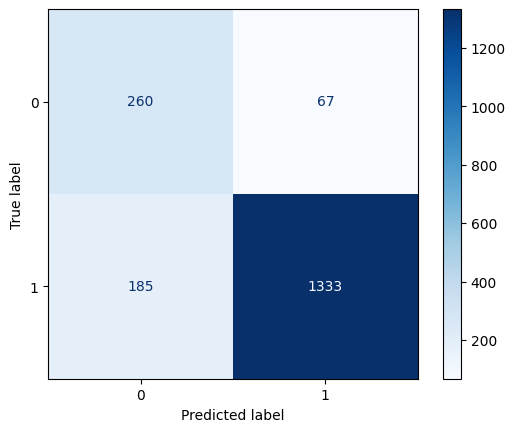

In [23]:
# Show basic confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['model'].classes_)
disp.plot(cmap="Blues")

In [27]:
# Show additional metrics
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1 Score:", round(f1_score(y_test, y_pred), 3))

Accuracy: 0.863
Precision: 0.952
Recall: 0.878
F1 Score: 0.914


### Fine-Tuning Pipeline

In [28]:
# Define base model (same as in Training)
base_clf = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    random_state=42,
)

In [29]:
# Combine preprocessor and model into single pipeline
tuned_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  
    ("model", base_clf),
])

In [30]:
# Define hyperparameter search space (TF-IDF (text) + classifier (LogReg))
param_grid = {
    # TF-IDF hyperparameters
    "preprocessor__text__tfidf__ngram_range": [(1,1), (1,2)],
    "preprocessor__text__tfidf__min_df": [1, 2, 5],
    "preprocessor__text__tfidf__max_df": [0.85, 0.95],

    # Logistic Regression hyperparameters
    "model__C": [0.5, 1.0, 2.0, 5.0],
    "model__solver": ["liblinear", "lbfgs"],  # both handle L2; liblinear is robust on sparse data
    "model__penalty": ["l2"],
}

In [31]:
# f1_macro due to class imbalance
grid = GridSearchCV(
    estimator=tuned_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1,
    refit=True, 
)

In [32]:
# Start search
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV f1_macro:", round(grid.best_score_, 4))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'model__C': 5.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'preprocessor__text__tfidf__max_df': 0.85, 'preprocessor__text__tfidf__min_df': 2, 'preprocessor__text__tfidf__ngram_range': (1, 2)}
Best CV f1_macro: 0.8136


In [36]:
#  Evaluate on hold-out test set
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("\nFinal Evaluation on Test Set (Best Model)")
print(classification_report(y_test, y_pred, digits=3))


Final Evaluation on Test Set (Best Model)
              precision    recall  f1-score   support

           0      0.634     0.752     0.688       327
           1      0.944     0.906     0.925      1518

    accuracy                          0.879      1845
   macro avg      0.789     0.829     0.807      1845
weighted avg      0.889     0.879     0.883      1845



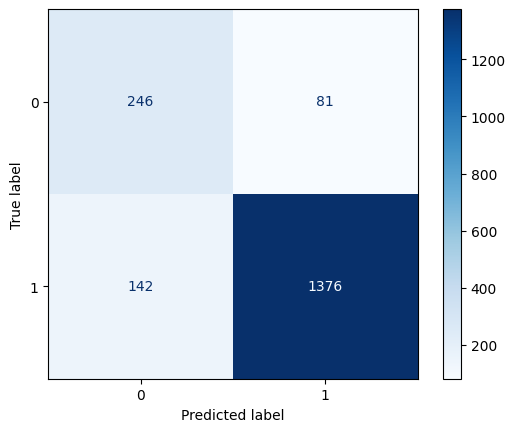

In [37]:
# Show confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")

In [38]:
# Additional metrics
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision (positive class=1):", round(precision_score(y_test, y_pred), 3))
print("Recall (positive class=1):", round(recall_score(y_test, y_pred), 3))
print("F1 (positive class=1):", round(f1_score(y_test, y_pred), 3))

Accuracy: 0.879
Precision (positive class=1): 0.944
Recall (positive class=1): 0.906
F1 (positive class=1): 0.925
